In [1]:
import torch
import pandas as pd 
import numpy as np
import torch.nn as nn
import torch.nn.functional as Fun
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler

In [28]:

import json
import numpy as np
with open('/Users/cynthia/Desktop/大三下课程/数据挖掘/code/data/TrainData.json','r') as file:
    train=json.load(file)
with open('/Users/cynthia/Desktop/大三下课程/数据挖掘/code/data/TestData.json','r') as file:
    test=json.load(file)

def normal(data):
    le=len(data)
    replace=[0]*len(data)
    maxx1=np.zeros(le)
    minn1=np.zeros(le)
    maxx2=np.zeros(le)
    minn2=np.zeros(le)
    maxx3=np.zeros(le)
    minn3=np.zeros(le)
    maxx4=np.zeros(le)
    minn4=np.zeros(le)
    for i in range(le):
        maxx1[i]=np.array(data[i]).ravel().reshape(-1,7).max(axis=0)[2]
        minn1[i]=np.array(data[i]).ravel().reshape(-1,7).min(axis=0)[2]
        maxx2[i]=np.array(data[i]).ravel().reshape(-1,7).max(axis=0)[3]
        minn2[i]=np.array(data[i]).ravel().reshape(-1,7).min(axis=0)[3]
        maxx3[i]=np.array(data[i]).ravel().reshape(-1,7).max(axis=0)[4]
        minn3[i]=np.array(data[i]).ravel().reshape(-1,7).min(axis=0)[4]
        maxx4[i]=np.array(data[i]).ravel().reshape(-1,7).max(axis=0)[5]
        minn4[i]=np.array(data[i]).ravel().reshape(-1,7).min(axis=0)[5]
    max1=maxx1.max()
    min1=minn1.min()
    max2=maxx2.max()
    min2=minn2.min()
    max3=maxx3.max()
    min3=minn3.min()
    max4=maxx4.max()
    min4=minn4.min()
    for i in range(le):
        a=np.array(data[i])[:,2:6].copy()
        b=np.zeros((a.shape[0],4))
        b[:,0]=(a[:,0]-min1)/(max1-min1)
        b[:,1]=(a[:,1]-min2)/(max2-min2)
        b[:,2]=(a[:,2]-min3)/(max3-min3)
        b[:,3]=(a[:,3]-min4)/(max4-min4)
        replace[i]=b.copy()
    return replace,[max1,min1,max1-min1],[max2,min2,max2-min2],[max3,min3,max3-min3],[max4,min4,max4-min4]

def moving(step,array):
    maxlength=array.shape[0]-step
    feature_X=np.zeros((maxlength,4*step))
    feature_y=np.zeros((maxlength,4))
    for i in range(maxlength):
        feature_X[i,:]=array[i:i+step,:].ravel()
        feature_y[i,:]=array[i+step,:]
    return feature_X,feature_y

def feature(data,length): #length:窗口长度
    listX=[0]*len(data)
    listY=[0]*len(data)
    i=0
    num=[0]
    for i in range(len(data)):
        if(np.array(data[i]).shape[0]<length):
            num.append(i)
            continue
        listX[i]=moving(length,np.array(data[i]))[0]
        listY[i]=moving(length,np.array(data[i]))[1]
    listX=[i for numi,i in enumerate(listX) if numi not in num[1:]]
    listY=[i for numi,i in enumerate(listY) if numi not in num[1:]]
    for i in range(len(listX)-1):
        listX[i+1]=np.vstack((listX[i],listX[i+1]))
        listY[i+1]=np.vstack((listY[i],listY[i+1]))
    return listX[len(listX)-1],listY[len(listY)-1]

norm_train=normal(train)[0]
norm_test=normal(test)[0]
norm_test
def itter(test,Len):
    num=[0]
    for i in range(len(test)):
        if(np.array(test[i]).shape[0]<=(Len+3)):
            num.append(i)
            continue
    test=[i for numi,i in enumerate(test) if numi not in num[1:]]
    predict=np.zeros((Len*len(test),4))
    nono=np.zeros((Len*len(test),4))
    for i in range(len(test)):
        original=torch.FloatTensor(np.array(test[i])[0:4,:].ravel())
        for j in range(Len):
            a=net(original).detach().numpy()
            predict[Len*i+j,:]=a
            nono[Len*i+j,:]=np.array(test[i])[4+j,:]
            original=torch.FloatTensor(np.hstack((original[4:16],a)))
    return predict,nono


In [4]:
a=np.array([1,1,1])
b=np.vstack((a,a))
b[1,:]

array([1, 1, 1])

In [5]:
from sklearn.metrics import mean_squared_error,r2_score
 
def evaluation(y_test, y_predict):
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    return rmse

In [8]:
def mainfun():
    n=20
    rmse_value=[0]*n
    for smooth in range(1,n+1):
        lr        = 0.02 # 学习率
        epochs    = 500  # 训练轮数 
        n_feature = 4*smooth   # 输入特征
        n_hidden  = 30   # 隐含层
        n_output  = 4    # 输出
        train_X=feature(norm_train,smooth)[0]
        train_y=feature(norm_train,smooth)[1]
        test_X=feature(norm_test,smooth)[0]
        test_y=feature(norm_test,smooth)[1]
        
        x_train=torch.FloatTensor(train_X)
        y_train=torch.FloatTensor(train_y)
        x_test=torch.FloatTensor(test_X)
        y_test=torch.FloatTensor(test_y)
        class BPNetModel(torch.nn.Module):
            def __init__(self,n_feature,n_hidden,n_output):
                super(BPNetModel, self).__init__()
                self.hiddden=torch.nn.Linear(n_feature,n_hidden)#定义隐层网络
                self.out=torch.nn.Linear(n_hidden,n_output)#定义输出层网络
            def forward(self,x):
                x=Fun.relu(self.hiddden(x)) #隐层激活函数采用relu()函数
                out=self.out(x) #输出层
                return out
            #定义优化器和损失函数
            #定义优化器和损失函数
        net=BPNetModel(n_feature=n_feature,n_hidden=n_hidden,n_output=n_output) #调用网络
        optimizer=torch.optim.Adam(net.parameters(),lr=lr) #使用Adam优化器，并设置学习率
        loss_fun=torch.nn.MSELoss() #多分类交叉熵损失函数
        #训练数据
        loss_steps=np.zeros(epochs) #构造一个array([ 0., 0., 0., 0., 0.])里面有epochs个0
        accuracy_steps=np.zeros(epochs)
        for epoch in range(epochs):
            y_pred=net(x_train) #前向传播
            loss=loss_fun(y_pred,y_train)#预测值和真实值对比
            optimizer.zero_grad() #梯度清零
            loss.backward() #反向传播
            optimizer.step() #更新梯度
            loss_steps[epoch]=loss.item()#保存loss
            running_loss = loss.item()
            #print(f"第{epoch}次训练，loss={running_loss}".format(epoch,running_loss))
        change=normal(test)
        y_predict=net(x_test).detach().numpy()
        ytest=y_test.detach().numpy()
        for i in range(4):
            y_predict[:,i]=y_predict[:,i]*change[1+i][2]+change[1+i][1]
            ytest[:,i]=ytest[:,i]*change[1+i][2]+change[1+i][1]
        rmse_value[smooth-1]=evaluation(ytest[:,0:2]*0.1,y_predict[:,0:2]*0.1)
    return rmse_value.index(min(rmse_value))+1,min(rmse_value),rmse_value
mainfun()

(2,
 1.1137749,
 [1.1286725,
  1.1137749,
  1.4521428,
  1.3136262,
  1.5471578,
  1.610989,
  1.3829916,
  1.2896899,
  1.6918637,
  1.4650996,
  1.7764312,
  1.5247269,
  2.089587,
  1.6482651,
  1.8674885,
  2.144341,
  1.9505525,
  1.9941534,
  2.122658,
  2.069059])



# 上面的mainfun函数选出最佳窗口值为2（从1-20里面选出来的），此时RMSE最小，接下来，我把2作为窗口值进行预测

In [6]:
smooth=4

train_X=feature(norm_train,smooth)[0]
train_y=feature(norm_train,smooth)[1]
test_X=feature(norm_test,smooth)[0]
test_y=feature(norm_test,smooth)[1]

x_train=torch.FloatTensor(train_X)
y_train=torch.FloatTensor(train_y)
x_test=torch.FloatTensor(test_X)
y_test=torch.FloatTensor(test_y)

In [8]:
lr        = 0.02 # 学习率
epochs    = 500  # 训练轮数 
n_feature = 4*smooth   # 输入特征
n_hidden  = 30   # 隐含层
n_output  = 4    # 输出

class BPNetModel(torch.nn.Module):
    def __init__(self,n_feature,n_hidden,n_output):
        super(BPNetModel, self).__init__()
        self.hiddden=torch.nn.Linear(n_feature,n_hidden)#定义隐层网络
        self.out=torch.nn.Linear(n_hidden,n_output)#定义输出层网络
    def forward(self,x):
        x=torch.tanh(self.hiddden(x)) #隐层激活函数采用relu()函数
        out=self.out(x) #输出层
        return out
#定义优化器和损失函数

In [9]:
#定义优化器和损失函数

net=BPNetModel(n_feature=n_feature,n_hidden=n_hidden,n_output=n_output) #调用网络
optimizer=torch.optim.Adam(net.parameters(),lr=lr) #使用Adam优化器，并设置学习率
loss_fun=torch.nn.MSELoss() #多分类交叉熵损失函数

In [10]:
#训练数据
loss_steps=np.zeros(epochs) #构造一个array([ 0., 0., 0., 0., 0.])里面有epochs个0
accuracy_steps=np.zeros(epochs)


In [11]:
for epoch in range(epochs):
    y_pred=net(x_train) #前向传播
    loss=loss_fun(y_pred,y_train)#预测值和真实值对比
    optimizer.zero_grad() #梯度清零
    loss.backward() #反向传播
    optimizer.step() #更新梯度
    loss_steps[epoch]=loss.item()#保存loss
    running_loss = loss.item()
    print(f"第{epoch}次训练，loss={running_loss}".format(epoch,running_loss))

第0次训练，loss=0.22569353878498077
第1次训练，loss=0.03503923490643501
第2次训练，loss=0.09009882807731628
第3次训练，loss=0.08299520611763
第4次训练，loss=0.036872390657663345
第5次训练，loss=0.028399620205163956
第6次训练，loss=0.04080801084637642
第7次训练，loss=0.04293345287442207
第8次训练，loss=0.0333431251347065
第9次训练，loss=0.02277124673128128
第10次训练，loss=0.018092559650540352
第11次训练，loss=0.01785852760076523
第12次训练，loss=0.017653172835707664
第13次训练，loss=0.0160142220556736
第14次训练，loss=0.013992800377309322
第15次训练，loss=0.01256628055125475
第16次训练，loss=0.01165944803506136
第17次训练，loss=0.01062466949224472
第18次训练，loss=0.009244524873793125
第19次训练，loss=0.00807679072022438
第20次训练，loss=0.00775948679074645
第21次训练，loss=0.00820047315210104
第22次训练，loss=0.008575865998864174
第23次训练，loss=0.008086058311164379
第24次训练，loss=0.006682214327156544
第25次训练，loss=0.005123333539813757
第26次训练，loss=0.004323295317590237
第27次训练，loss=0.004607765004038811
第28次训练，loss=0.005461953114718199
第29次训练，loss=0.005894409026950598
第30次训练，loss=0.005274270195513964
第31次训练，l

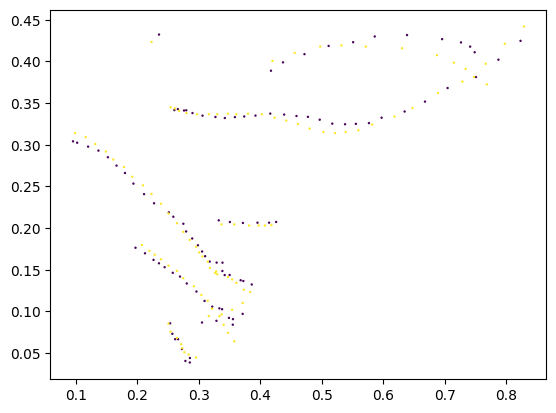

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
predict_test=net(x_test).detach().numpy()
scatter_plot = plt.figure()
axes1 = scatter_plot.add_subplot(1, 1, 1)
axes1.scatter( 
    x=list(predict_test[1:100,0])+list(test_y[1:100,0]),
    y=list(predict_test[1:100,1])+list(test_y[1:100,1]),
    s=[0.5]*(predict_test[1:100,0].shape[0]+test_y[1:100,0].shape[0]),
    c=[1]*predict_test[1:100,0].shape[0]+[2]*test_y[1:100,0].shape[0],
    alpha=1 ) 

In [13]:
#归一化后的rmse
y_predict=net(x_test).detach().numpy()
ytest=y_test.detach().numpy()
evaluation(ytest,y_predict)

0.026280701

In [14]:
#逆归一化
import os
change=normal(test)
y_predict=net(x_test).detach().numpy()
ytest=y_test.detach().numpy()
for i in range(4):
    y_predict[:,i]=y_predict[:,i]*change[1+i][2]+change[1+i][1]
    ytest[:,i]=ytest[:,i]*change[1+i][2]+change[1+i][1]
#逆归一化的rmse
evaluation(ytest[:,0:2]*0.1,y_predict[:,0:2]*0.1)
ytest

array([[ 213., 1121.,  998.,   15.],
       [ 225., 1123., 1000.,   13.],
       [ 237., 1126., 1002.,   13.],
       ...,
       [  84., 1005., 1006.,   13.],
       [  89.,  996., 1006.,   13.],
       [  99.,  990., 1008.,   13.]], dtype=float32)

In [920]:
ytest[:,0:2]=ytest[:,0:2]*0.1
y_predict[:,0:2]=y_predict[:,0:2]*0.1

array([[  21.300001,  112.1     ,  998.      ,   15.      ],
       [  22.5     ,  112.3     , 1000.      ,   13.      ],
       [  23.7     ,  112.6     , 1002.      ,   13.      ],
       ...,
       [   8.400001,  100.5     , 1006.      ,   13.      ],
       [   8.900001,   99.6     , 1006.      ,   13.      ],
       [   9.900001,   99.      , 1008.      ,   13.      ]],
      dtype=float32)

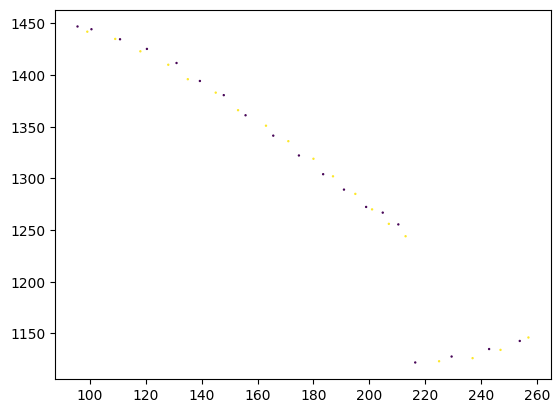

In [898]:
import matplotlib.pyplot as plt
import seaborn as sns
scatter_plot = plt.figure()
axes1 = scatter_plot.add_subplot(1, 1, 1)
axes1.scatter( 
    x=list(y_predict[1:20,0])+list(ytest[1:20,0]),
    y=list(y_predict[1:20,1])+list(ytest[1:20,1]),
    s=[0.5]*(y_predict[1:20,0].shape[0]+ytest[1:20,0].shape[0]),
    c=[1]*y_predict[1:20,0].shape[0]+[2]*ytest[1:20,0].shape[0],
    alpha=1 ) 

In [899]:
newy=pd.read_csv('/Users/cynthia/Desktop/大三下课程/数据挖掘/test_original.csv')
change=normal(test)
for i in range(4):
    newy.iloc[:,i]=(newy.iloc[:,i]-change[1+i][1])/(change[1+i][2])
X=moving(4,newy.values)[0]
Y=moving(4,newy.values)[1]

In [900]:
X_tor=torch.FloatTensor(X)
Y_tor=torch.FloatTensor(X)

In [901]:
Y_pre=net(X_tor).detach().numpy()
Y_test=Y.copy()
for i in range(4):
    Y_pre[:,i]=Y_pre[:,i]*change[1+i][2]+change[1+i][1]
    Y_test[:,i]=Y_test[:,i]*change[1+i][2]+change[1+i][1]
Y_pre[:,0:2]=Y_pre[:,0:2]*0.1
Y_test[:,0:2]=Y_test[:,0:2]*0.1

In [902]:
evaluation(Y_test[:,0:2],Y_pre[:,0:2])

1.3002031626896056

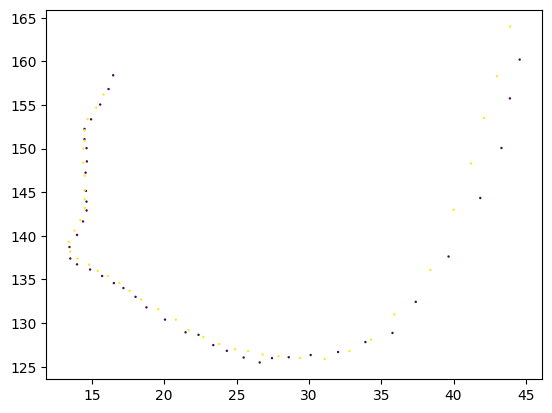

In [903]:
import matplotlib.pyplot as plt
import seaborn as sns
scatter_plot = plt.figure()
axes1 = scatter_plot.add_subplot(1, 1, 1)
axes1.scatter( 
    x=list(Y_pre[:,0])+list(Y_test[:,0]),
    y=list(Y_pre[:,1])+list(Y_test[:,1]),
    s=[0.5]*(Y_pre[:,0].shape[0]+Y_test[:,0].shape[0]),
    c=[1]*Y_pre[:,0].shape[0]+[2]*Y_test[:,0].shape[0],
    alpha=1 ) 

# 一直迭代下去

In [44]:
for i in range(len(test)):
    print(np.array(test[i]).shape[0])

9
31
10
15
12
19
31
33
24
20
25
53
13
21
9
34
12
36
29
46
41
27
31
34
31
16
12
17
34
25
27
21
21
15
82
33
14
34
31
33
30
27
26
21
40
22
16
53
22
13
9
25
35
30
21
23
12
40
26
19
26
32
15
50
26
32
30
53
53
52
14
22
62
12
36
53
21
63
64
44
48
31
27
46
52
30
53
39
54
7
36
36
13
20
17
48
11
18
8
17
37
21
31
34
62
48
38
24
45
37
37
16
16
27
37
39
29
30
13
34
28
30
44
25
45
37
37
25
16
55
29
15
17
21
29
37
35
18
37
25
54
20
20
10
30
13
26
44
39
18
33
30


In [31]:

four_ypre=itter(norm_test,4)[0]
four_y=itter(norm_test,4)[1]
for i in range(4):
    four_ypre[:,i]=(four_ypre[:,i]*change[1+i][2])+(change[1+i][1])
    four_y[:,i]=(four_y[:,i]*change[1+i][2])+(change[1+i][1])
four_ypre[:,0:2]=four_ypre[:,0:2]*0.1
four_y[:,0:2]=four_y[:,0:2]*0.1
evaluation(four_ypre[:,0:2],four_y[:,0:2])


1.9487651964927262

In [45]:
four_y[20:24,0:2]

array([[ 16.2, 124.7],
       [ 16.9, 123.7],
       [ 17.4, 123. ],
       [ 18. , 122.2]])

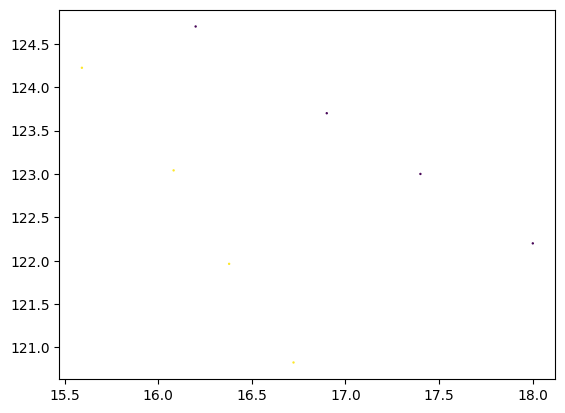

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
scatter_plot = plt.figure()
axes1 = scatter_plot.add_subplot(1, 1, 1)
axes1.scatter( 
    x=list(four_y[20:24,0])+list(four_ypre[20:24,0]),
    y=list(four_y[20:24,1])+list(four_ypre[20:24,1]),
    s=[0.5]*8,
    c=[1]*4+[2]*4,
    alpha=1 ) 

In [27]:
ev_ypre=itter(norm_test,8)[0]
ev_y=itter(norm_test,8)[1]
for i in range(4):
    ev_ypre[:,i]=(ev_ypre[:,i]*change[1+i][2])+(change[1+i][1])
    ev_y[:,i]=(ev_y[:,i]*change[1+i][2])+(change[1+i][1])
ev_ypre[:,0:2]=ev_ypre[:,0:2]*0.1
ev_y[:,0:2]=ev_y[:,0:2]*0.1
evaluation(ev_ypre[:,0:2],ev_y[:,0:2])

3.2134863115202212

In [47]:
ev_y[24:32,:]

array([[ 16.2, 124.7, 990. ,  23. ],
       [ 16.9, 123.7, 985. ,  25. ],
       [ 17.4, 123. , 985. ,  25. ],
       [ 18. , 122.2, 982. ,  28. ],
       [ 18.7, 121.1, 982. ,  28. ],
       [ 19.5, 120.2, 982. ,  28. ],
       [ 20.1, 118.9, 980. ,  30. ],
       [ 21.1, 117.5, 975. ,  33. ]])

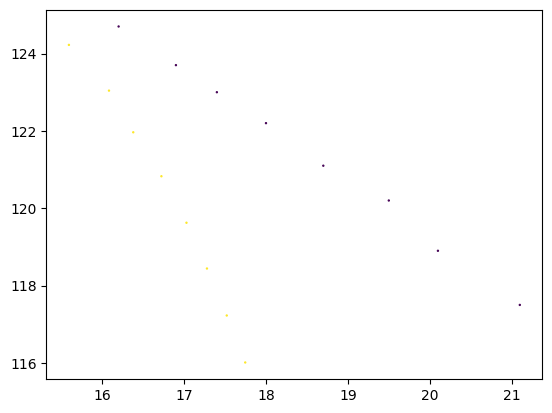

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
scatter_plot = plt.figure()
axes1 = scatter_plot.add_subplot(1, 1, 1)
axes1.scatter( 
    x=list(ev_y[24:32,0])+list(ev_ypre[24:32,0]),
    y=list(ev_y[24:32,1])+list(ev_ypre[24:32,1]),
    s=[0.5]*16,
    c=[1]*8+[2]*8,
    alpha=1 ) 

In [29]:
seven_ypre=itter(norm_test,12)[0]
seven_y=itter(norm_test,12)[1]
for i in range(4):
    seven_ypre[:,i]=(seven_ypre[:,i]*change[1+i][2])+(change[1+i][1])
    seven_y[:,i]=(seven_y[:,i]*change[1+i][2])+(change[1+i][1])
seven_ypre[:,0:2]=seven_ypre[:,0:2]*0.1
seven_y[:,0:2]=seven_y[:,0:2]*0.1
evaluation(seven_ypre[:,0:2],seven_y[:,0:2])

4.670698560190896

In [48]:
seven_y[12:24,0:2]

array([[ 16.2, 124.7],
       [ 16.9, 123.7],
       [ 17.4, 123. ],
       [ 18. , 122.2],
       [ 18.7, 121.1],
       [ 19.5, 120.2],
       [ 20.1, 118.9],
       [ 21.1, 117.5],
       [ 21.8, 116. ],
       [ 22.4, 115. ],
       [ 22.8, 113.6],
       [ 23.5, 112.3]])

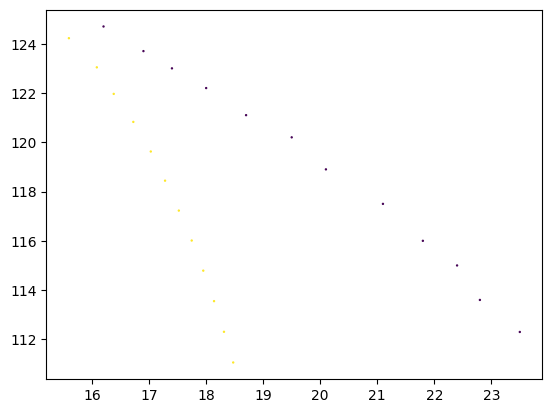

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
scatter_plot = plt.figure()
axes1 = scatter_plot.add_subplot(1, 1, 1)
axes1.scatter( 
    x=list(seven_y[12:24,0])+list(seven_ypre[12:24,0]),
    y=list(seven_y[12:24,1])+list(seven_ypre[12:24,1]),
    s=[0.5]*24,
    c=[1]*12+[2]*12,
    alpha=1 ) 

In [ ]:
data41=pd.DataFrame(seven_ypre[:,0:2])
data41.to_csv('/Users/cynthia/Desktop/大三下课程/数据挖掘/length4_predict.csv')
data42=pd.DataFrame(seven_y[:,0:2])
data42.to_csv('/Users/cynthia/Desktop/大三下课程/数据挖掘/length4_test.csv')

128.0

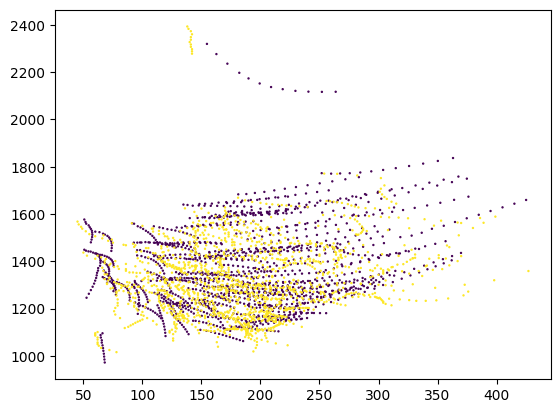

In [908]:
import matplotlib.pyplot as plt
import seaborn as sns
scatter_plot = plt.figure()
axes1 = scatter_plot.add_subplot(1, 1, 1)
axes1.scatter( 
    x=list(seven_ypre[:,0])+list(seven_y[:,0]),
    y=list(seven_ypre[:,1])+list(seven_y[:,1]),
    s=[0.5]*(seven_ypre[:,0].shape[0]+seven_y[:,0].shape[0]),
    c=[1]*seven_ypre[:,0].shape[0]+[2]*seven_y[:,0].shape[0],
    alpha=1 ) 

In [866]:
data41=pd.DataFrame(Y_pre)
data41.to_csv('/Users/cynthia/Desktop/大三下课程/数据挖掘/length4_predict.csv')

data42=pd.DataFrame(Y_test)
data42.to_csv('/Users/cynthia/Desktop/大三下课程/数据挖掘/length4_test.csv')

In [922]:
data1=pd.DataFrame(y_predict)
data1.to_csv('/Users/cynthia/Desktop/大三下课程/数据挖掘/y_predict.csv')
ytest=y_test.detach().numpy()
data2=pd.DataFrame(ytest)
data2.to_csv('/Users/cynthia/Desktop/大三下课程/数据挖掘/y_test.csv')